# Exploring results for NAS with DMRL [V3]

## Global imports and variables

In [1]:
# Import for interactive notebook (see:
# https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

# Import to list files in directories
import glob

# Import for regular expressions
import re

# Imports for path operations
import os
import os.path

# For date operations
from datetime import datetime

import pandas as pd
pd.set_option('max_colwidth', -1)
import matplotlib.pyplot as plt

import numpy as np
import configparser

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')


In [2]:
RESULTS_DIR = "/Users/gomerudo/workspace/thesis_results"

def rettext(text):
    return text

def search_in_file(file, pattern):
    pattern = re.compile(pattern)
    results = []
    for i, line in enumerate(open(file)):
        for match in re.finditer(pattern, line):
            results.append(match.groups())
    return results

form_item_layout = Layout(
    width="50%"
)

w_resdirs = interactive(
    rettext,
    text=sorted(glob.glob("{dir}/[0-9]*".format(dir=RESULTS_DIR))),
    layout=form_item_layout
)

## Selecting the desired results

In [3]:
display(w_resdirs)

interactive(children=(Dropdown(description='text', options=('/Users/gomerudo/workspace/thesis_results/26630', …

## Results

In [4]:
################################################################################
############ OBTAIN THE FILES AND DIRECTORIES TO QUERY FOR ANALYSIS ############
################################################################################

# Obtain the chosen directory
chosen_dir = w_resdirs.result

# experiments dir
exp_dir = glob.glob("{dir}/experiment*[!.zip]".format(dir=chosen_dir))[0]

# This is a list of all openai dirs, sorted by name (hence, by timestamp)
openai_dirs = sorted(glob.glob("{dir}/openai*[!.zip]".format(dir=exp_dir)))

# A simple DB of experiments and actions_info.csv should be there
dbexp_file = glob.glob("{dir}/db*".format(dir=exp_dir))[0]
ainfo_file = glob.glob("{dir}/act*".format(dir=exp_dir))[0]
config_file = glob.glob("{dir}/config.ini".format(dir=exp_dir))[0]
flog_file = glob.glob("{dir}/sl*".format(dir=chosen_dir))[0]

# Make dataframes for the db of experiments and the actions summary
dbexp_df = pd.read_csv(dbexp_file)
ainfo_df = pd.read_csv(ainfo_file)

In [5]:
################################################################################
########### BUILD THE RELEVANT DATA FRAMES TO PRINT FOR MAIN SUMMARY ###########
################################################################################
    
# Try to obtain the current times
# running_times = search_in_file(flog_file, ".*\s+(.*)elapsed")
# if len(running_times) == len(openai_dirs):
#     f_running_times = []
#     for time in running_times:
#         time_cleansed = time[0].split(".")[0]
#         f_running_times.append(time_cleansed)
# else:
prev_timestamp = 0
f_running_times = []
for directory in openai_dirs:
    exp_dirname_only = os.path.basename(directory)
    timestamp = os.path.basename(exp_dirname_only.split("-")[1])
    d2 = datetime.strptime(timestamp, "%Y%m%d%H%M%S")
    if prev_timestamp:  # 2019 05 29 211533
        d1 = datetime.strptime(prev_timestamp, "%Y%m%d%H%M%S")
        f_running_times.append(str(d2 - d1))
    prev_timestamp = timestamp
f_running_times.append("NA")

openai_dirs_df = pd.DataFrame(zip(openai_dirs, f_running_times), columns=["Log directory", "Runtime"])

# 4. Search all exceptions
exceptions_all = search_in_file(flog_file, "failed with exception of type.*<(.*)>.*Message.*:\s*(.*)")
n_exceptions = len(exceptions_all)

exceptions_set = set()
for error, message in exceptions_all:
    exceptions_set.add(error)

config = configparser.ConfigParser()

_ = config.read(config_file)

### Summary

- **Chosen results directory is:** {{chosen_dir}}
- **Full log is available at:** {{flog_file}}

#### Configuration

- **Log Path:** {{config['DEFAULT']['LogPath']}}
- **Environment:** {{config['bash']['Environment']}}

##### Reinforcement Learning

- **Algorithm:** {{config['bash']['Algorithm']}}
- **Policy representation:** {{config['bash']['Network']}}
- **Number of steps:** {{config['bash']['NSteps']}}
- **Total number of timestamps:** {{config['bash']['NumTimesteps']}}
- **Number of trials:** {{config['bash']['NTrials']}}
- **Number of actions:** {{ainfo_df.shape[0]}}

##### NAS details

- **Config file:** {{config['nasenv.default']['ConfigFile']}}
- **Max Steps:** {{config['nasenv.default']['MaxSteps']}}
- **DB of experiments:** {{config['nasenv.default']['DbFile']}}
- **Dataset Handler:** {{config['nasenv.default']['DatasetHandler']}}
- **Action Space Type:** {{config['nasenv.default']['ActionSpaceType']}}
- **Trainer:** {{config['nasenv.default']['TrainerType']}}

##### Training details

- **Batch size:** {{config['trainer.default']['BatchSize']}}
- **Epochs:** {{config['trainer.default']['NEpochs']}}
- **Distributed:** {{config['trainer.tensorflow']['EnableDistributed']}}

##### Meta-dataset details

- **TFRecordsRootDir:** {{config['metadataset']['TFRecordsRootDir']}}
- **DatasetID:** {{config['metadataset']['DatasetID']}}

#### Individual run directories/time

{{openai_dirs_df}}

#### Errors found in log while building networks

- **Total number of exceptions:** {{n_exceptions}}

{{pd.DataFrame(exceptions_set, columns = ["Error type"])}}

In [7]:
def trial_summary(trial_log):
    # Read in try catch because the file can be corrupted or might not exist
    try:
        # Read the log file
        trial_df = pd.read_csv(trial_log)
        actions_distribution = [0]*ainfo_df.shape[0]
        
        # CONTROL VARIABLES
        # Info for the best architecture
        best_architecture = None
        best_reward = -1

        # Aux for episode control
        max_step_ep = 0
        best_reward_ep = 0

        # History lists
        max_step_count_history = []
        best_reward_history = []
        all_rewards_history = []

        # Accumulated rewards per trial
        acc_rewards_history = []
        acc_reward = 0
        # Iterate the log
        for idx, row in trial_df.iterrows():
            
            # Obtain the information information
            action_id = int(row['action_id'])
            step = int(row['step_count'])
            is_valid = bool(row['valid'])
            arch_hash = row['end_state_hashed']
            reward = float(row['reward'])
            
            # THIS SECTION IS FOR THE "OVERALL" STATISTICS IN TRIAL
            # a) Add information to the distribution of actions
            actions_distribution[action_id] += 1
    
            # b) Get the best reward by comparing one by one
            if reward > best_reward:
                best_reward = reward
                best_architecture = arch_hash

            # c) History of all rewards in trial
            all_rewards_history.append(reward)
            
            # d) Unique architectures
            unique_architectures.add(arch_hash)

            # THIS SECTION IS FOR THE EPISODE STATISTICS
            if step > max_step_ep:
                max_step_ep = step
                best_reward_ep = reward if reward > best_reward_ep else best_reward_ep
                acc_reward += reward
            # Otherwise, append the best information we read
            else:
                max_step_count_history.append(max_step_ep)
                best_reward_history.append(best_reward_ep)
                acc_rewards_history.append(acc_reward)
                max_step_ep = step
                best_reward_ep = reward
                acc_reward = reward
    except Exception:
        pass
    finally:
        return {
            'actions_distribution': actions_distribution,
            'max_step_history': max_step_count_history,
            'best_reward_history': best_reward_history,
            'all_rewards_history': all_rewards_history,
            'best_architecture': best_architecture,
            'best_reward': best_reward,
            'n_episodes': len(best_reward_history),
            'unique_architectures': set(trial_df['end_state_hashed'].unique()),
            'acc_rewards_history': acc_rewards_history,
        }

# Obtain statistics for each trial 
stats = []
for i, openai_dir in enumerate(openai_dirs):
    try:
        trial_log = sorted(glob.glob("{dir}/episode_logs/*".format(dir=openai_dir)))[0]
        info_trial = trial_summary(trial_log)
        stats.append(info_trial)
    except IndexError:
        print("Could not read the episode_logs in {}".format(openai_dir))
        pass
    
# Build global statistics for the whole experiment
n_episodes_history = []
unique_architectures = set()
last_length_set_archs = len(unique_architectures)
best_global_architecture = None
best_global_reward = 0

global_best_reward_history = []
global_all_rewards_history = []
global_max_step_history = []
new_archs_history = []

for trial_stats in stats:
    # Miscellaneous
    n_episodes_history.append(len(trial_stats['best_reward_history']))
    unique_architectures.update(trial_stats['unique_architectures'])
    new_sampled_architectures = len(unique_architectures) - last_length_set_archs
    last_length_set_archs = len(unique_architectures)
    new_archs_history.append(new_sampled_architectures)
    
    # Best values
    if trial_stats['best_reward'] > best_global_reward:
        best_global_reward = trial_stats['best_reward']
        best_global_architecture = trial_stats['best_architecture']
        
    # Global histories
    global_best_reward_history += trial_stats['best_reward_history']
    global_max_step_history += trial_stats['max_step_history']
    
    
    # The distribution of actions
total_n_episodes = sum(n_episodes_history)

# Search for the best architecture
best_architecture_id = "{d}-{h}".format(d=config['metadataset']['DatasetID'], h=best_global_architecture)
best_architecture_dbexp = dbexp_df.loc[dbexp_df['dataset-nethash'] == best_architecture_id].iloc[0]

### Global statistics for experiment

- **True number of trials:** {{len(stats)}}
- **Total number of episodes:** {{total_n_episodes}}
- **Number of unique architectures:** {{len(unique_architectures)}}
- **Best architecture in experiment:** {{best_global_architecture}}
- **Best reward in experiment:** {{best_global_reward}}

#### The best architecture

```{{for layer in best_architecture_dbexp['netstring'].split("\n"):  print(layer)}}```


**Main information**

- **ID:** {{best_architecture_dbexp['dataset-nethash']}}
- **Index in DB:** {{best_architecture_dbexp.name}}
- **Is valid?** {{best_architecture_dbexp['is_valid']}}
- **Accuracy:** {{best_architecture_dbexp['accuracy']}}
- **Training time (in sec):** {{best_architecture_dbexp['running_time']}}
- **Density:** {{best_architecture_dbexp['density']}}
- **FLOPs:** {{best_architecture_dbexp['flops']}}


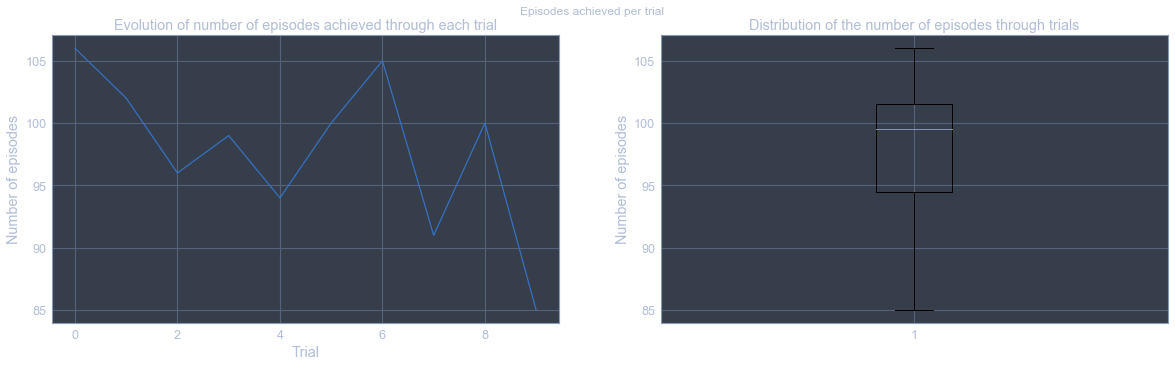

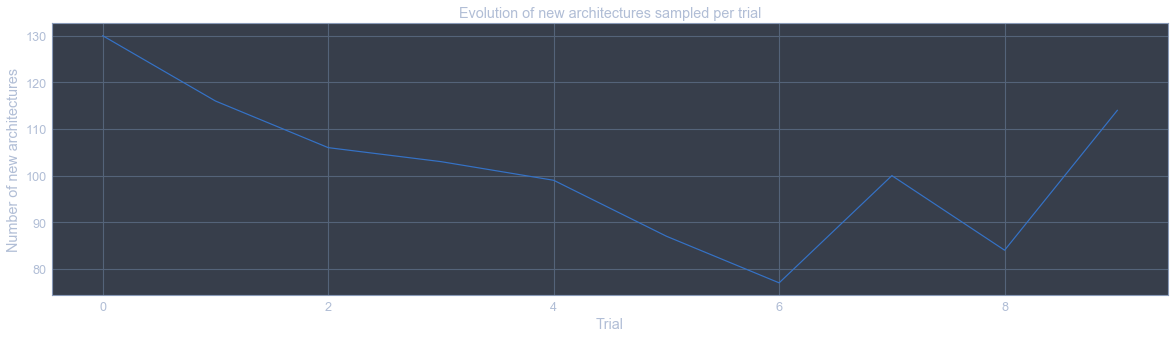

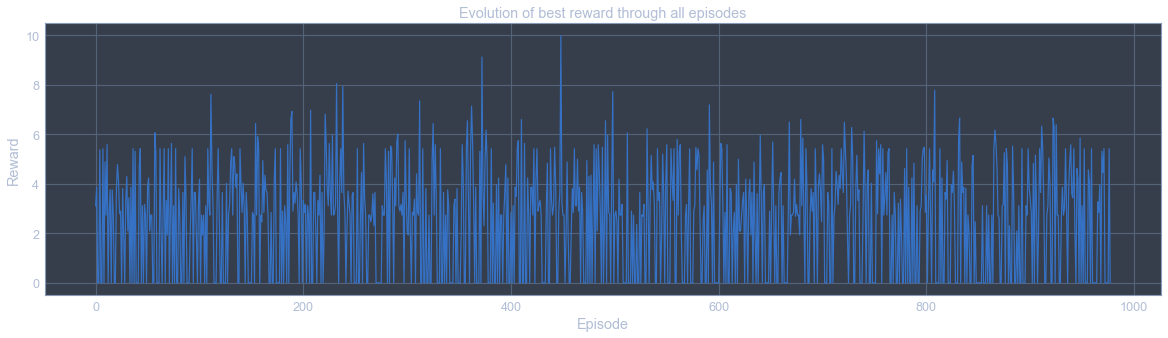

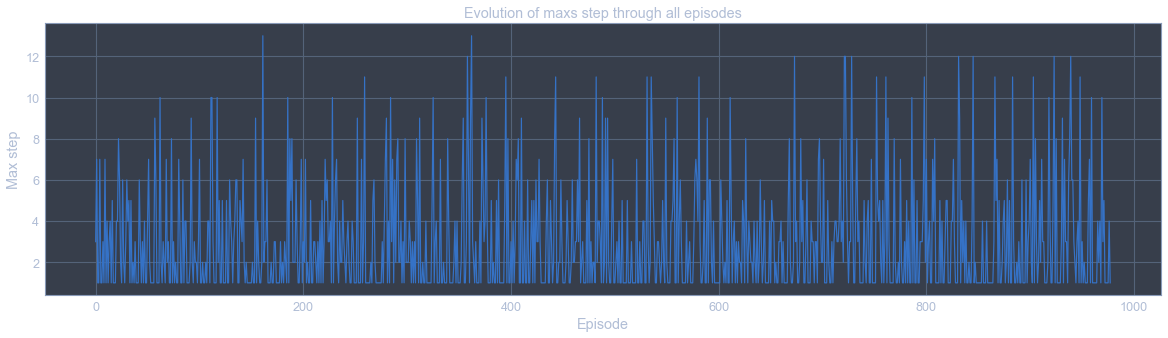

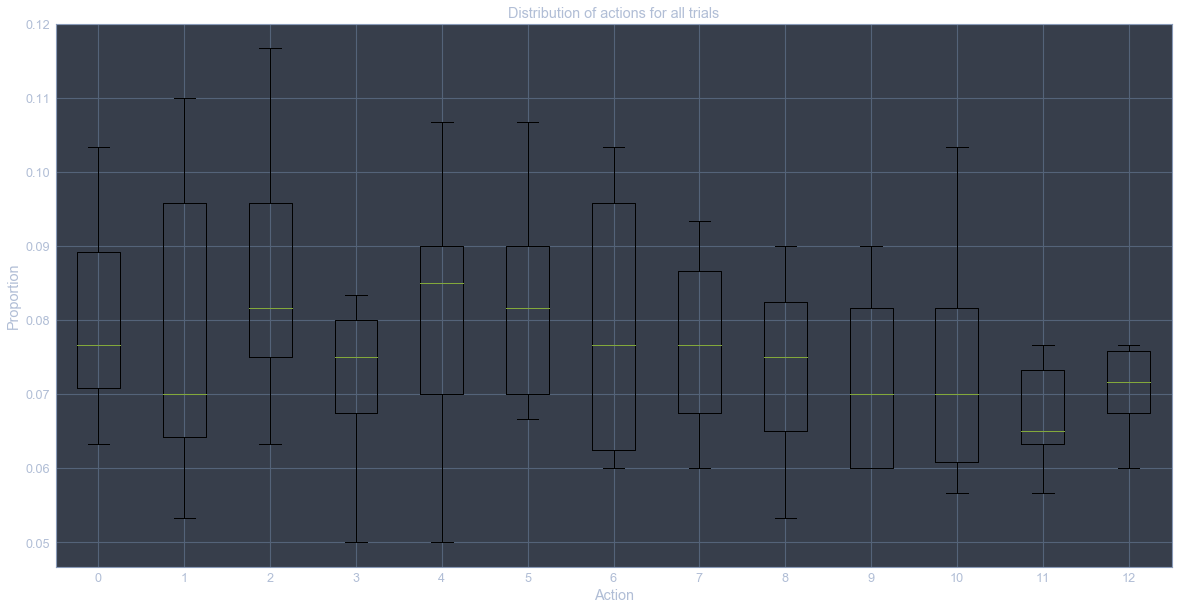

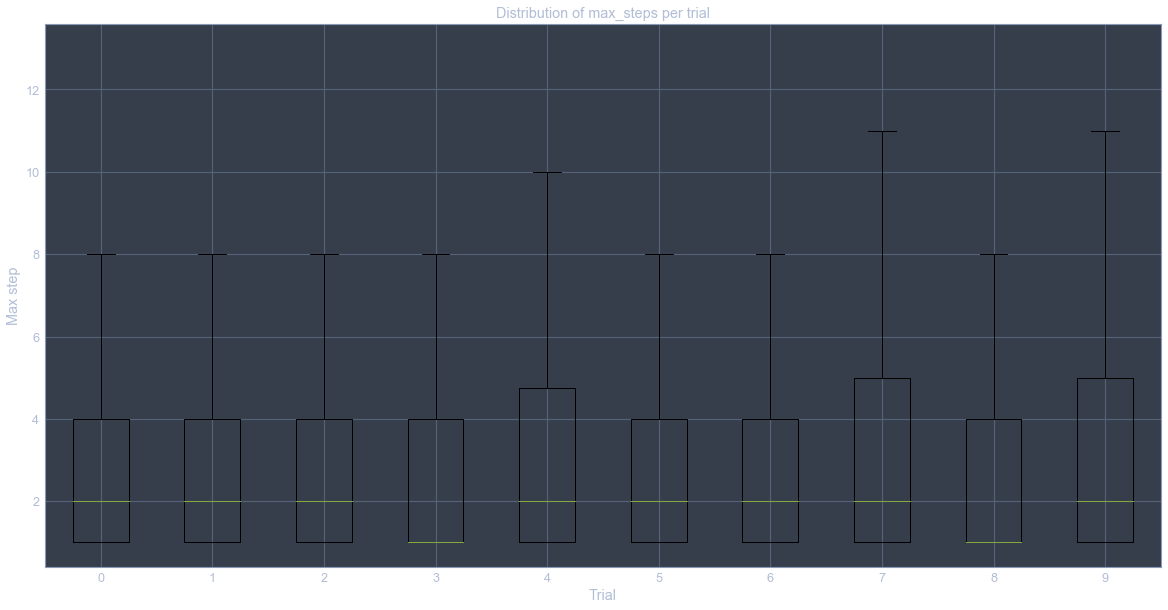

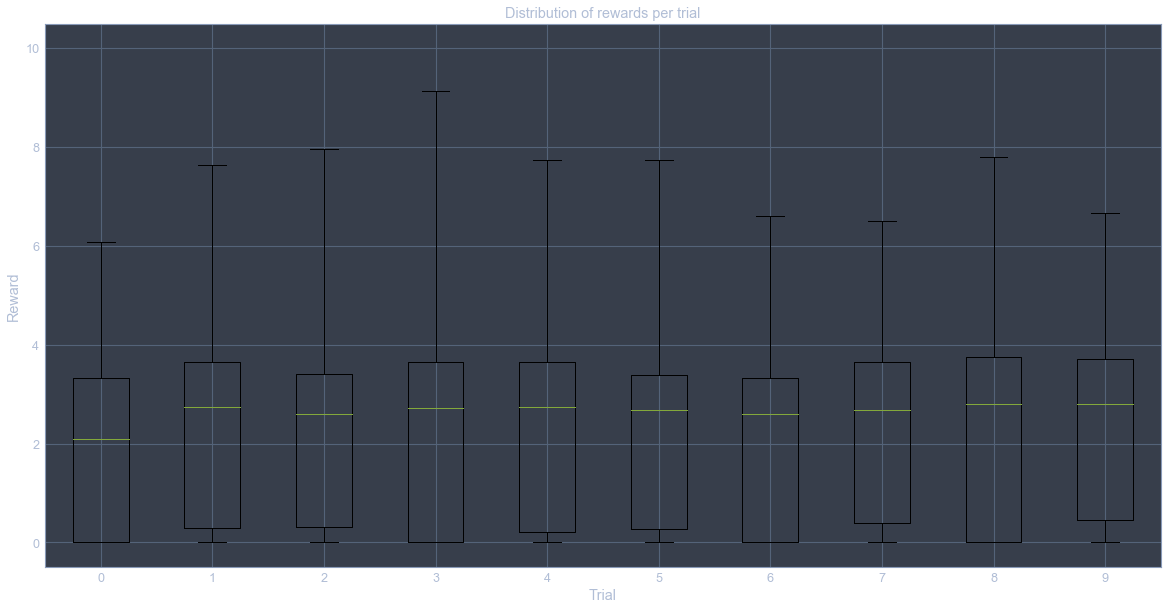

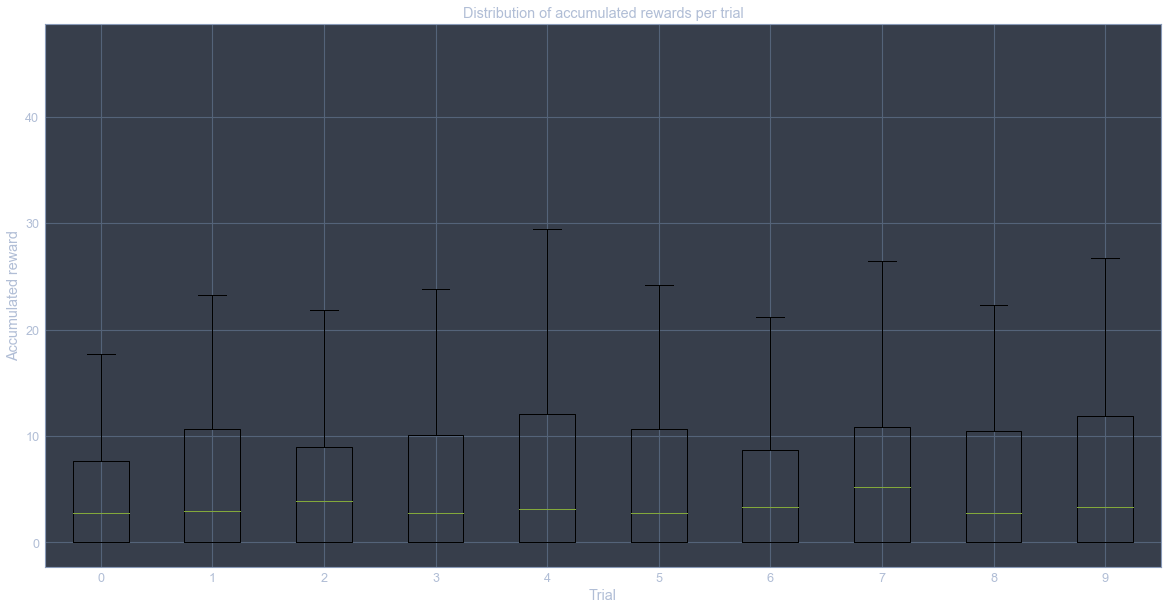

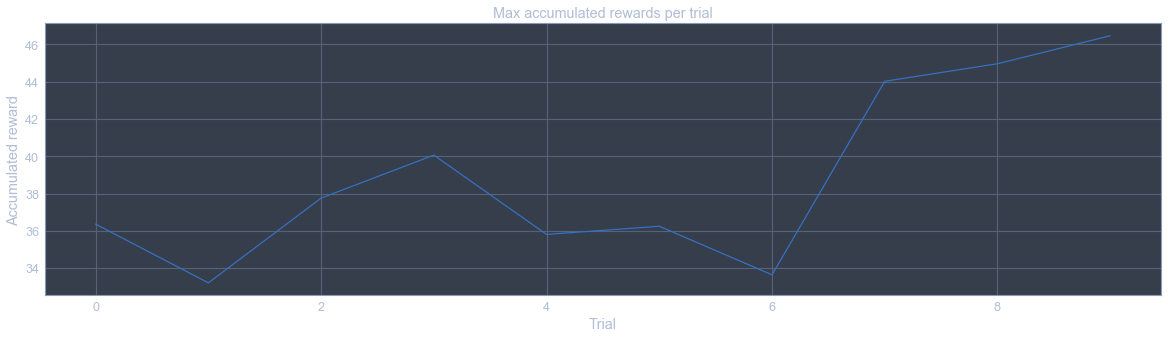

In [8]:
%matplotlib inline

# import seaborn as sns
# sns.set()

# Plot the episodes achieved per trial
fig, axes = plt.subplots(nrows = 1, ncols=2)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.8)
fig.set_size_inches(20, 5)
fig.suptitle("Episodes achieved per trial")
# Plot 1
c_ax = axes[0]
c_ax.set_title("Evolution of number of episodes achieved through each trial")
c_ax.set_xlabel("Trial")
c_ax.set_ylabel("Number of episodes")
c_ax.plot(n_episodes_history)
# Plot 2
c_ax = axes[1]
c_ax.set_title("Distribution of the number of episodes through trials")
c_ax.set_ylabel("Number of episodes")
c_ax.boxplot(n_episodes_history)

# Plot the evolution of new architectures tried per trial
plt.figure(figsize=(20, 5))
plt.title("Evolution of new architectures sampled per trial")
plt.xlabel("Trial")
plt.ylabel("Number of new architectures")
_ = plt.plot(new_archs_history)
plt.show()


# Plot the evolution of best reward
plt.figure(figsize=(20, 5))
plt.title("Evolution of best reward through all episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")
_ = plt.plot(global_best_reward_history)
plt.show()

# Plot the evolution of max steps
plt.figure(figsize=(20, 5))
plt.title("Evolution of maxs step through all episodes")
plt.xlabel("Episode")
plt.ylabel("Max step")
_ = plt.plot(global_max_step_history)
plt.show()

# Plot the actions' distribution
plt.figure(figsize=(20, 10))
plt.title("Distribution of actions for all trials")
plt.xlabel("Action")
plt.ylabel("Proportion")
res = []
for trial_stats in stats:
    np_arr = np.array(trial_stats['actions_distribution']) / sum(trial_stats['actions_distribution'])
    res.append(np_arr)
res = np.array(res)
_ = plt.boxplot(res, positions=range(res.shape[1]))
plt.show()

# Plot the distribution of max_steps per trial
plt.figure(figsize=(20, 10))
plt.title("Distribution of max_steps per trial")
plt.xlabel("Trial")
plt.ylabel("Max step")
# plt.ylim([])
res = []
for trial_stats in stats:
    np_arr = np.array(trial_stats['max_step_history'])
    res.append(np_arr)
_ = plt.boxplot(res, positions=range(len(res)))
plt.show()

# Plot the distribution of rewards per trial
plt.figure(figsize=(20, 10))
plt.title("Distribution of rewards per trial")
plt.xlabel("Trial")
plt.ylabel("Reward")
# plt.ylim([0,11])
res = []
for trial_stats in stats:
    np_arr = np.array(trial_stats['all_rewards_history'])
    res.append(np_arr)
_ = plt.boxplot(res, positions=range(len(res)))
plt.show()

# Plot the distribution of accumulated rewards per trial
plt.figure(figsize=(20, 10))
plt.title("Distribution of accumulated rewards per trial")
plt.xlabel("Trial")
plt.ylabel("Accumulated reward")
res = []
for trial_stats in stats:
    np_arr = np.array(trial_stats['acc_rewards_history'])
    res.append(np_arr)
_ = plt.boxplot(res, positions=range(len(res)))
plt.show()


# Plot the max accumulated reward per trial
plt.figure(figsize=(20, 5))
plt.title("Max accumulated rewards per trial")
plt.xlabel("Trial")
plt.ylabel("Accumulated reward")
res = []
for trial_stats in stats:
    max_acc_reward = max(trial_stats['acc_rewards_history'])
    res.append(max_acc_reward)
_ = plt.plot(range(len(res)), res)
plt.show()


### Visualizing the learning curves of the RL policy and value function

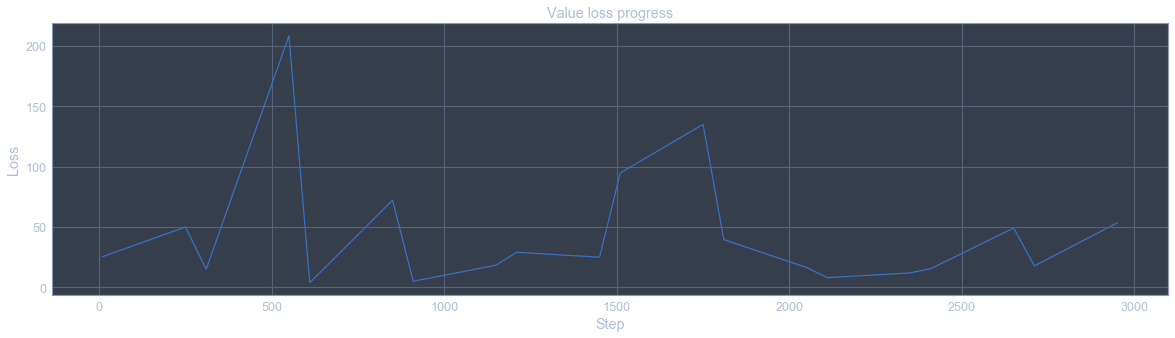

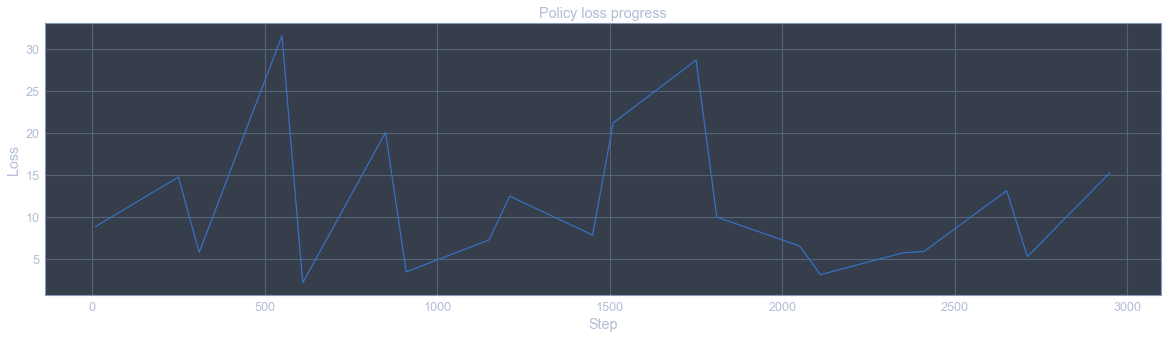

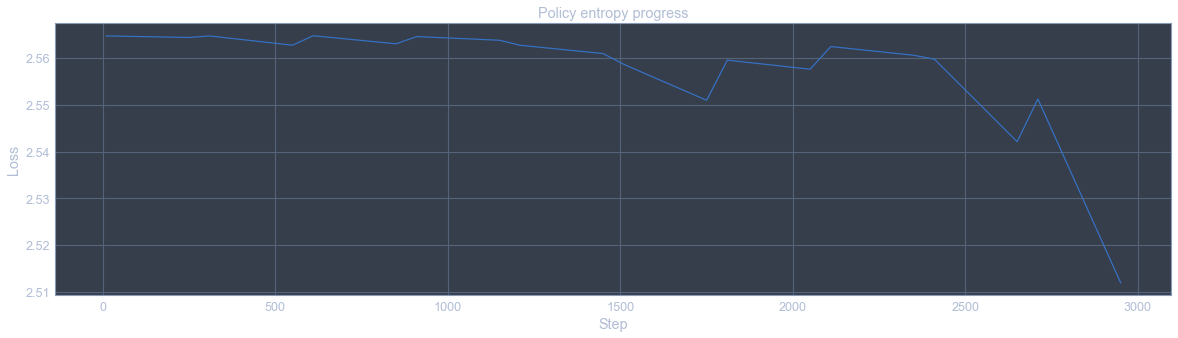

In [9]:
progress_df = None
for i, openai_dir in enumerate(openai_dirs):
    try:
        progress_log = "{dir}/progress.csv".format(dir=openai_dir)
        df_aux = pd.read_csv(progress_log)
        if progress_df is None:
            progress_df = df_aux.copy()
        else:
            progress_df = progress_df.append(df_aux)
    except FileNotFoundError:
        print("Could not read the episode_logs in {}".format(openai_dir))
        pass

import math

tsteps_trial = int(float(config['bash']['NumTimesteps']))
factor = 240
helpers = np.resize([0,1], progress_df.shape[0])
increases = np.array([[tsteps_trial*x, tsteps_trial*x] for x in range(math.ceil(progress_df.shape[0]/2))]).flatten()
updates_list = [factor*h + 10 + i for x, h, i in zip(range(progress_df.shape[0]), helpers, increases) ]

plt.figure(figsize=(20, 5))
plt.title("Value loss progress")
plt.xlabel("Step")
plt.ylabel("Loss")
_ = plt.plot(updates_list, progress_df['value_loss'])
plt.show()

plt.figure(figsize=(20, 5))
plt.title("Policy loss progress")
plt.xlabel("Step")
plt.ylabel("Loss")
_ = plt.plot(updates_list, progress_df['policy_loss'])
plt.show()

plt.figure(figsize=(20, 5))
plt.title("Policy entropy progress")
plt.xlabel("Step")
plt.ylabel("Loss")
_ = plt.plot(updates_list, progress_df['policy_entropy'])
plt.show()